## Detached 
### Predikcia secondary__equivalent_radius

In [1]:
# LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# pip install keras

     |████████████████████████████████| 1.4 MB 7.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# pip install --upgrade tensorflow

     |████████████████████████████████| 497.6 MB 2.7 kB/s  eta 0:00:01     |████████                        | 124.5 MB 26.0 MB/s eta 0:00:15     |███████████████████████▏        | 359.8 MB 40.4 MB/s eta 0:00:04     |███████████████████████▌        | 365.0 MB 40.4 MB/s eta 0:00:04
     |████████████████████████████████| 14.5 MB 63.8 MB/s eta 0:00:01
     |████████████████████████████████| 16.8 MB 54.9 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 56.0 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 55.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 41.7 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 48.1 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalle

In [23]:
# pip install --upgrade tensorflow-gpu

     |████████████████████████████████| 497.6 MB 2.8 kB/s  eta 0:00:01   |█▉                              | 29.0 MB 6.8 MB/s eta 0:01:09
Note: you may need to restart the kernel to use updated packages.


In [27]:
# pip install np_utils

     |████████████████████████████████| 61 kB 577 kB/s eta 0:00:011
  Created wheel for np-utils: filename=np_utils-0.6.0-py3-none-any.whl size=56445 sha256=b3bc12f36de07d3042594194a73107b7706e509f2e402eae18dee21a889d4933
  Stored in directory: /home/jovyan/.cache/pip/wheels/55/8b/e7/a23fd46c709c21e3e6fcb55978d88b018f80d54018459978c3
Successfully built np-utils
Note: you may need to restart the kernel to use updated packages.


In [2]:
from keras.utils import np_utils
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Dropout, Flatten
from keras.models import Model
from keras.layers.merge import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
np.random.seed(1234)

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
def generate_observation_sigma(space_obs_frac=0.5):
    """
    Draws a standard deviation of noise in light curve points from a "true" value provided in synthetic light curve.
    Noise sigma is drawn from bimodal distribution taking into account contributions from space based and earth based
    observations which have different levels of stochastic noise.

    :param space_obs_frac: ratio between earth based and space based observations
    :return: float; standard deviation of the light curve noise
    """
    earth_based_sigma = 4e-3
    space_based_sigma = 2e-4
    sigma = np.random.choice([earth_based_sigma, space_based_sigma], p=[1-space_obs_frac, space_obs_frac])
    return np.random.rayleigh(sigma)

def stochastic_noise_generator(curve):
    """
    Introduces gaussian noise into synthetic observation provided in `curve`.

    :param curve: numpy.array; normalized light curve
    :return: Tuple(numpy.array, float); normalized light curve with added noise, standard deviation of observations
    """
    sigma = generate_observation_sigma()
    return np.random.normal(curve, sigma), np.full(curve.shape, sigma)

### Data Loading

In [6]:
data = pd.read_pickle("detached_all_parameters.pkl").reset_index() 

In [ ]:
data.head()

,index,id,curve,primary__t_eff,secondary__t_eff,inclination,mass_ratio,primary__surface_potential,secondary__surface_potential,t1_t2,filter,critical_surface_potential,primary__equivalent_radius,secondary__equivalent_radius,primary__filling_factor,secondary__filling_factor
0,0,38,"[0.6055271686415179, 0.9842041250556204, 0.999...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_U,15.09104,0.009996,0.009996,-145.333979,-1502.830354
1,1,38,"[0.608985656265516, 0.9846965713304289, 0.9998...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_B,15.09104,0.009996,0.009996,-145.333979,-1502.830354
2,2,38,"[0.6189025614226916, 0.9837351924934223, 0.999...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_V,15.09104,0.009996,0.009996,-145.333979,-1502.830354
3,3,38,"[0.6292771409565273, 0.9832675811171884, 0.999...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_R,15.09104,0.009996,0.009996,-145.333979,-1502.830354
4,4,38,"[0.6543378609145588, 0.9835188424579704, 0.999...",7000,4000,1.560796,10.0,110.00005,996.5005,1.75,Bessell_I,15.09104,0.009996,0.009996,-145.333979,-1502.830354


In [7]:
data_sample=data.sample(n=100000)
data_sample["filter"].value_counts()

Kepler       7794
SLOAN_i      7784
SLOAN_u      7764
Bessell_B    7760
Bessell_R    7732
Bessell_U    7726
SLOAN_z      7686
SLOAN_g      7676
GaiaDR2      7657
SLOAN_r      7638
TESS         7608
Bessell_V    7607
Bessell_I    7568
Name: filter, dtype: int64

## Data preparation and split

In [8]:
X = []
for row in data_sample["curve"]:
    X.append(row)
X=np.array(X)

y = np.array(data_sample["secondary__equivalent_radius"])

In [9]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
X_train = []
y_train = []
for i in range(len(X_train1)):
    for j in range(3):
        curve = stochastic_noise_generator(X_train1[i])
        X_train.append(curve[0])
        y_train.append(y_train1[i])
X_train = np.array(X_train)
y_train=np.array(y_train)

In [11]:
print("Number of records in dataset: ", len(data),
    "\nNumber of records in sample: ", len(X), 
    "\nNumber of train data without noise: ", len(X_train1), 
    "\nNumber of train data with noise: ", len(X_train),
    "\nNumber of test data without noise: ", len(X_test))

Number of records in dataset:  1300000 
Number of records in sample:  100000 
Number of train data without noise:  80000 
Number of train data with noise:  240000 
Number of test data without noise:  20000


### Model

In [14]:
inputs = Input(shape=(400, 1))
b = Conv1D(64, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Dropout(0.2)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
x = Dense(32, activation='relu')(b)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 398, 64)           256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 64)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 199, 64)           0         
                                                                 
 lstm (LSTM)                 (None, 199, 64)           33024     
                                                                 
 flatten (Flatten)           (None, 12736)             0         
                                                             

In [15]:
saved_model = "models/detached_sec_radius.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

In [16]:
history = model.fit(X_train, y_train, validation_split = 0.1, epochs = 15, verbose = 1, callbacks = callbacks_list, batch_size = 64)

Epoch 1/15
3375/3375 [==============================] - ETA: 0s - loss: 0.0105 - mae: 0.0725 - mape: 105.3330
Epoch 1: val_mae improved from inf to 0.06512, saving model to detached_sec_radius.hdf5
3375/3375 [==============================] - 399s 118ms/step - loss: 0.0105 - mae: 0.0725 - mape: 105.3330 - val_loss: 0.0076 - val_mae: 0.0651 - val_mape: 62.9491
Epoch 2/15
3375/3375 [==============================] - ETA: 0s - loss: 0.0059 - mae: 0.0586 - mape: 75.8727
Epoch 2: val_mae improved from 0.06512 to 0.04977, saving model to detached_sec_radius.hdf5
3375/3375 [==============================] - 397s 118ms/step - loss: 0.0059 - mae: 0.0586 - mape: 75.8727 - val_loss: 0.0042 - val_mae: 0.0498 - val_mape: 71.3803
Epoch 3/15
3375/3375 [==============================] - ETA: 0s - loss: 0.0042 - mae: 0.0492 - mape: 62.2549
Epoch 3: val_mae improved from 0.04977 to 0.04478, saving model to detached_sec_radius.hdf5
3375/3375 [==============================] - 402s 119ms/step - loss: 0.00

In [12]:
model = load_model("models/detached_sec_radius.hdf5")

In [18]:
# Evaluate on synthetic test data - without noise
model.evaluate(X_test, y_test)

625/625 [==============================] - 20s 31ms/step - loss: 0.0018 - mae: 0.0296 - mape: 34.4629


[0.001814316026866436, 0.029584646224975586, 34.46285629272461]

In [13]:
# Add noise to synthetic test data
X_test_n = []
y_test_n = []
for i in range(len(X_test)):
    for j in range(3):
        curve = stochastic_noise_generator(X_test[i])
        X_test_n.append(curve[0])
        y_test_n.append(y_test[i])
        j += 1

In [14]:
X_test_n = np.array(X_test_n)
y_test_n = np.array(y_test_n)

In [21]:
# Evaluate on synthetic test data - with noise
model.evaluate(X_test_n, y_test_n)

1875/1875 [==============================] - 58s 31ms/step - loss: 0.0021 - mae: 0.0314 - mape: 38.9686


[0.0020851821172982454, 0.03141169250011444, 38.968563079833984]

## Prediction on synthetic test data - without noise

In [15]:
y_pred = model.predict(X_test)

In [16]:
y_pred = np.reshape(y_pred, len(y_pred))
df = pd.DataFrame(data = {'y_test': y_test, 'y_predict': y_pred})
df["diff"] = df["y_test"]-df["y_predict"]
df["abs_diff"] = abs(df["diff"])
df["relative_error"] = df["abs_diff"] / df["y_test"]
df.head()

,y_test,y_predict,diff,abs_diff,relative_error
0,0.249770,0.216874,0.032896,0.032896,0.131705
1,0.209660,0.075376,0.134284,0.134284,0.640484
2,0.210329,0.240359,-0.030030,0.030030,0.142778
3,0.250978,0.267461,-0.016483,0.016483,0.065674
4,0.089977,0.142683,-0.052706,0.052706,0.585776


In [17]:
df_mean = df.groupby(["y_test"])
df_mean = pd.DataFrame(df_mean.relative_error.mean()).reset_index()
a = df_mean.y_test.array.astype(str)
b = df_mean.relative_error.array
df_mean.head()

,y_test,relative_error
0,0.009996,1.572681
1,0.009996,3.278041
2,0.009996,5.478807
3,0.009996,0.912548
4,0.009996,3.523181


C:\Users\nemci\AppData\Local\Temp\ipykernel_14768\820374618.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b="on")


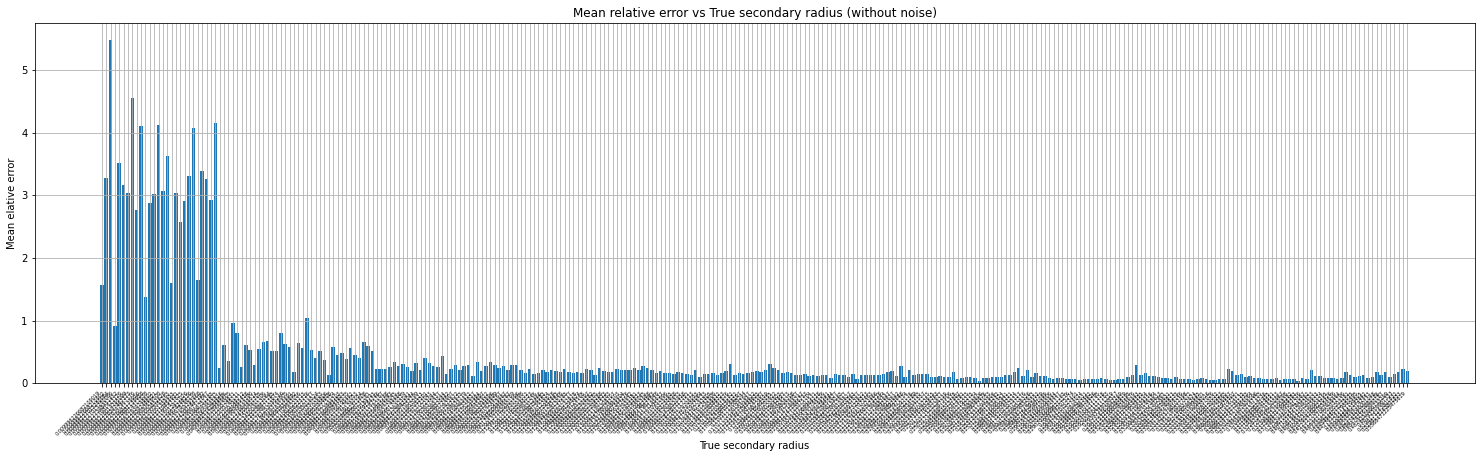

In [18]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
true = a
rel = b
ax.bar(true, rel)
ax.set_ylabel("Mean elative error")
ax.set_xlabel("True secondary radius")
ax.set_title("Mean relative error vs True secondary radius (without noise)")
plt.xticks(rotation=45, ha='right', fontsize = 5)
plt.grid(b="on")

plt.show()

## Comparison of true and predicted values - synthetic test data without noise

In [19]:
# Sample of true and predicted values
# true_sample = y_test[0:50]
# pred_sample = y_pred[0:50]
idx = np.random.choice(np.arange(len(y_test)), 50, replace=False)
true_sample = y_test[idx]
pred_sample = y_pred[idx]

In [20]:
comp = pd.DataFrame(data={"true_radius": true_sample,
                        "predicted_radius": pred_sample})
comp["diff"] = comp.true_radius - comp.predicted_radius
comp["abs_diff"] = abs(comp["diff"])
comp["relative_error"] = comp["abs_diff"]/comp["true_radius"]
comp.head()

,true_radius,predicted_radius,diff,abs_diff,relative_error
0,0.329094,0.308195,0.020898,0.020898,0.063503
1,0.249770,0.212462,0.037309,0.037309,0.149371
2,0.130946,0.134096,-0.003150,0.003150,0.024056
3,0.210971,0.201653,0.009318,0.009318,0.044169
4,0.049984,0.094692,-0.044708,0.044708,0.894433


C:\Users\nemci\AppData\Local\Temp\ipykernel_14768\1455540349.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b="on")


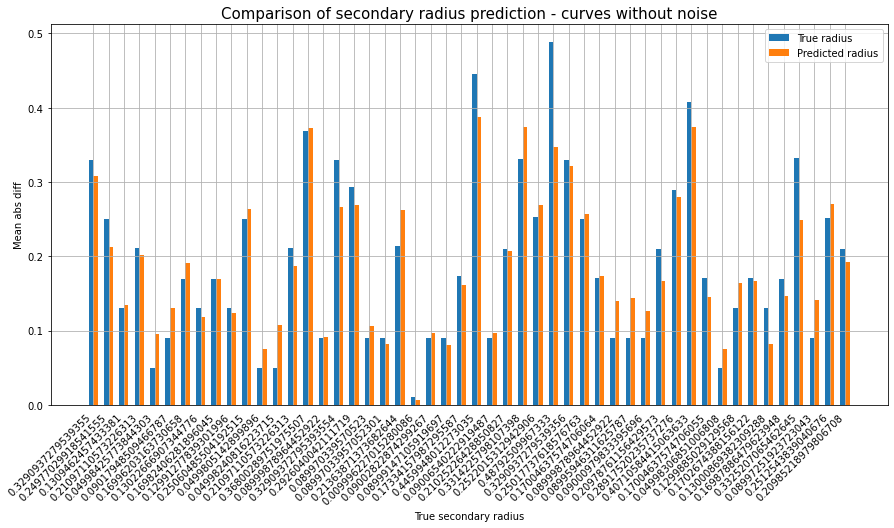

In [21]:
fig, ax = plt.subplots(figsize=(15,7))
x = np.arange(len(comp))
width = 0.3
plt.bar(x-0.15, comp.true_radius, width, label='True radius')
plt.bar(x+0.15, comp.predicted_radius, width, label='Predicted radius')
plt.title('Comparison of secondary radius prediction - curves without noise', fontsize=15)
plt.xticks(x, comp.true_radius, rotation=45, ha='right')
ax.set_ylabel("Mean abs diff")
ax.set_xlabel("True secondary radius")
ax.grid(False)
ax.tick_params(bottom=False, left=True)
plt.legend()
plt.grid(b="on")
plt.show()

## Prediction on synthetic test data - with noise

In [22]:
y_pred_n = model.predict(X_test_n)

In [23]:
y_pred_n = np.reshape(y_pred_n, len(y_pred_n))
df_n=pd.DataFrame(data={'y_test_n': y_test_n, 'y_predict_n': y_pred_n})
df_n["diff"]=df_n["y_test_n"]-df_n["y_predict_n"]
df_n["abs_diff"]=abs(df_n["diff"])
df_n["relative_error"] = df_n["abs_diff"]/df_n["y_test_n"]
df_n.head()

,y_test_n,y_predict_n,diff,abs_diff,relative_error
0,0.24977,0.223282,0.026488,0.026488,0.106050
1,0.24977,0.217395,0.032375,0.032375,0.129620
2,0.24977,0.216362,0.033408,0.033408,0.133754
3,0.20966,0.079489,0.130171,0.130171,0.620866
4,0.20966,0.069184,0.140476,0.140476,0.670020


In [24]:
df_mean_n = df_n.groupby(["y_test_n"])
df_mean_n = pd.DataFrame(df_mean_n.relative_error.mean()).reset_index()
a_n = df_mean_n.y_test_n.array.astype(str)
b_n = df_mean_n.relative_error.array
df_mean_n.head()

,y_test_n,relative_error
0,0.009996,1.715276
1,0.009996,3.748052
2,0.009996,5.329139
3,0.009996,1.166814
4,0.009996,3.951911


C:\Users\nemci\AppData\Local\Temp\ipykernel_14768\1663360381.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b="on")


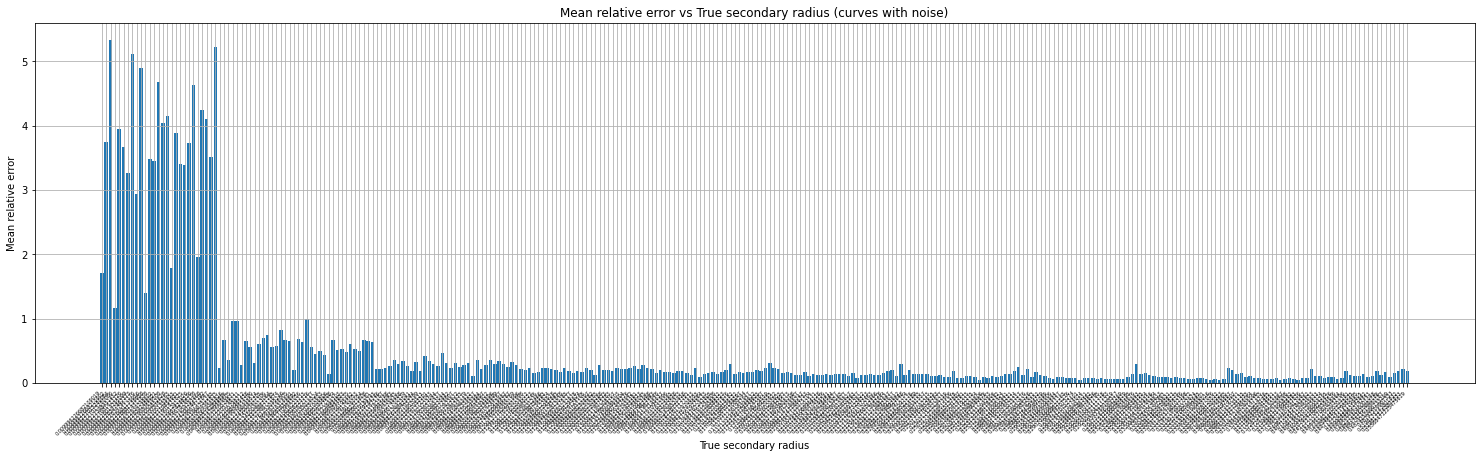

In [25]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
true = a_n
mean = b_n
ax.bar(true, mean)
ax.set_ylabel("Mean relative error")
ax.set_xlabel("True secondary radius")
ax.set_title("Mean relative error vs True secondary radius (curves with noise)")
plt.xticks(rotation=45, ha='right', fontsize = 5)
plt.grid(b="on")

plt.show()

## Comparison of true and predicted values - synthetic test data with noise

In [26]:
# Sample of true and predicted values
# true_sample_n = y_test_n[0:50]
# pred_sample_n = y_pred_n[0:50]

idx = np.random.choice(np.arange(len(y_test_n)), 50, replace=False)
true_sample_n = y_test_n[idx]
pred_sample_n = y_pred_n[idx]

In [27]:
comp_n = pd.DataFrame(data={"true_radius": true_sample_n,
                        "predicted_radius": pred_sample_n})
comp_n["diff"] = comp_n.true_radius - comp_n.predicted_radius
comp_n["abs_diff"] = abs(comp_n["diff"])
comp_n["relative_error"] = comp_n["abs_diff"]/comp_n["true_radius"]
comp_n.head()

,true_radius,predicted_radius,diff,abs_diff,relative_error
0,0.089966,0.069186,0.020780,0.020780,0.230981
1,0.289907,0.298967,-0.009060,0.009060,0.031250
2,0.329964,0.318016,0.011948,0.011948,0.036210
3,0.169851,0.136757,0.033094,0.033094,0.194841
4,0.331423,0.347176,-0.015754,0.015754,0.047534


C:\Users\nemci\AppData\Local\Temp\ipykernel_14768\972057078.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b="on")


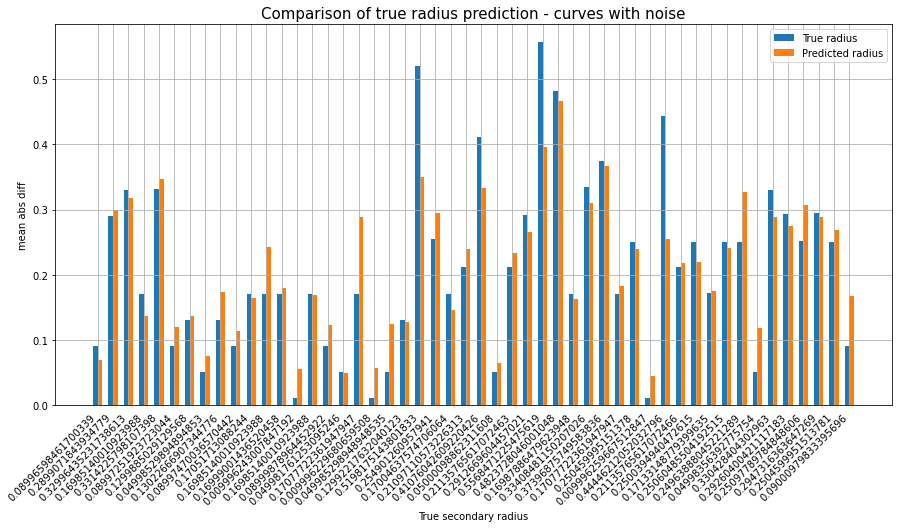

In [28]:
fig, ax = plt.subplots(figsize=(15,7))
x = np.arange(len(comp_n))
width = 0.3
plt.bar(x-0.15, comp_n.true_radius, width, label='True radius')
plt.bar(x+0.15, comp_n.predicted_radius, width, label='Predicted radius')
plt.title('Comparison of true radius prediction - curves with noise', fontsize=15)
plt.xticks(x, comp_n.true_radius, rotation=45, ha='right')
ax.set_ylabel("mean abs diff")
ax.set_xlabel("True secondary radius")
ax.grid(False)
ax.tick_params(bottom=False, left=True)
plt.legend()
plt.grid(b="on")
plt.show()